In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold

from parse_sensor_data import *

In [2]:
FEAT_CKPT = "../data/gnss_feats.pkl"
REFRESH_FEAT = True

## 数据

### 读取数据

In [3]:
records = extract_data_from_directory(DATA_FOLDER, ["GNSS", 'light', 'mobile'])
df_sat = explode_sat_data(records)


2023-12-13 00:04:44.819 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_北环-自驾_out_20231212-211519.zip
2023-12-13 00:04:44.887 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_上梅林-地铁站_in_20231125-184008.zip
2023-12-13 00:04:44.990 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_新一代-1层_out_20231212-185034.zip
2023-12-13 00:04:45.113 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_上梅林-九号路_out_20231114-180410.zip
2023-12-13 00:04:45.474 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_新一代产业园_in_20231208-185638.zip
2023-12-13 00:04:45.628 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_新一代-30层_in_20231212-192554.zip
2023-12-13 00:04:45.738 | DEBUG    | parse_sensor_data:extract_data_from_directory:245 - process: z_深圳_上梅林-星巴克_in_20231127-125841.zip
2023-12-13 00:04:45.790 | DEBUG    | parse_sensor_data:extract_

### 特征工程

In [4]:
if REFRESH_FEAT and not os.path.exists(FEAT_CKPT):
    # step 1: delete `NaN` 
    df_sat = reduce_mem_usage(df_sat)
    df_sat.satFrequency = np.round((df_sat.satFrequency / 1e6).values, 2)

    # step 2: delete `cache`
    df_sat = delete_cache_gnss_records(df_sat)

    # step 3: Pipeline 
    feat_lst, tag_2_feats = feature_pipline_for_GNSS(df_sat, records)
    feats, tag_2_feats = postprocess_feature(records, feat_lst, tag_2_feats, drop_high_coor_col_thred=0.99)
    save_feats(records, df_sat, feats, feat_lst, tag_2_feats, fn=FEAT_CKPT)
else:
    records, df_sat, feats, feat_lst, tag_2_feats = load_feats(FEAT_CKPT)
    

In [5]:
feats

,satCount,useSatCount,satDb_count,satDb_mean,satDb_std,satDb_25%,coverage_percentage,snr_std_dev,lis,lis_0,...,satTye_5-satDbBin_3-satDb_std,satTye_1-satDbBin_4-satDb_std,satTye_5-satDbBin_4-satDb_std,satTye_1-satIdentification_nunique,satTye_2-satIdentification_nunique,satTye_3-satIdentification_nunique,satTye_4-satIdentification_nunique,satTye_5-satIdentification_nunique,satTye_6-satIdentification_nunique,label
1,59,0,2.0,23.150001,0.450000,22.925001,0.055556,0.636396,1.0,0.0,...,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,True
2,68,0,4.0,23.450000,1.357387,22.425001,0.111111,1.567375,2.0,1.0,...,0.000000,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,True
3,68,0,7.0,22.457143,1.703658,21.200000,0.138889,2.031502,4.0,3.0,...,0.000000,0.0,0.0,1.0,0.0,3.0,0.0,0.0,3.0,True
4,68,0,15.0,22.153334,2.717319,20.050000,0.222222,2.475070,4.0,3.0,...,0.000000,0.0,0.0,6.0,0.0,4.0,1.0,1.0,3.0,True
5,81,0,18.0,21.527778,1.901112,19.600000,0.277778,1.641744,6.0,3.0,...,0.000000,0.0,0.0,6.0,0.0,5.0,1.0,2.0,4.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6588,69,46,58.0,28.015517,6.342299,24.300001,0.722222,7.423188,12.0,6.0,...,1.838158,0.0,0.0,8.0,1.0,6.0,3.0,25.0,5.0,False
6589,69,43,58.0,26.787931,5.625161,24.200001,0.722222,6.757239,12.0,6.0,...,1.477869,0.0,0.0,8.0,1.0,6.0,3.0,25.0,5.0,False
6590,69,45,61.0,26.990164,6.436416,23.299999,0.750000,7.042494,12.0,11.0,...,2.281413,0.0,0.0,8.0,1.0,6.0,3.0,27.0,5.0,False
6591,69,47,60.0,28.181667,6.471257,24.550000,0.722222,7.269956,12.0,5.0,...,2.057544,0.0,0.0,8.0,1.0,6.0,3.0,26.0,5.0,False


### 数据切分

In [6]:
""" step 4: 切分数据 """
data_loader = group_kfold_split(feats, feats[LABEL], records.loc[feats.index].fn, n_splits=5)
X_train, y_train, X_valid, y_valid = next(data_loader)

2023-12-13 00:04:52.727 | DEBUG    | parse_sensor_data:group_kfold_split:126 - Training: ['z_深圳_上梅林-中康路_out_20231121-181755.zip', 'z_深圳_上梅林-中康路南行_out_20231114-175517.zip', 'z_深圳_上梅林-九号路_out_20231114-180410.zip', 'z_深圳_上梅林-九号路_out_20231121-185019.zip', 'z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip', 'z_深圳_上梅林-卓越城_out_20231125-183631.zip', 'z_深圳_上梅林-周边_out_20231115-090731.zip', 'z_深圳_上梅林-地铁站_in_20231125-184008.zip', 'z_深圳_上梅林-星巴克_in_20231127-125841.zip', 'z_深圳_上梅林-理想城_out_20231121-185830.zip', 'z_深圳_上梅林-站厅_in_20231114-210530.zip', 'z_深圳_上梅林-站外5m_out_20231114-181054.zip', 'z_深圳_上梅林-站外_out_20231114-183323.zip', 'z_深圳_上梅林地铁站-站厅_in_20231208-190308.zip', 'z_深圳_上梅林地铁站-站厅_in_20231208-190937.zip', 'z_深圳_上梅林地铁站-站台_in_20231208-191209.zip', 'z_深圳_南山地铁站-E口外_out_20231116-072412.zip', 'z_深圳_新一代-肯德基_in_20231125-183152.zip', 'z_深圳_新一代产业园_in_20231208-185638.zip', 'z_深圳_新一代产业园_out_20231208-185221.zip', 'z_深圳_新一代产业园_out_20231208-190219.zip', 'z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip']
2023-12-13 00:04:52.731 |

In [7]:
""" step 5：特征选择 """
feature_comparison, useful_feature_names = null_importance_feature_selection(X_train, y_train, X_train.columns, 200, 42)
# useful_feature_names = rfecv_feature_selection(X_train, y_train, get_sklearn_model("LR"))
useful_feature_names


['useSatCount',
 'satDb_mean',
 'satDb_25%',
 'coverage_percentage',
 'lis_1',
 'lis_2',
 'satDbBin_3-satDb_count',
 'satDbBin_3-satDb_mean',
 'satDbBin_3-satDb_std',
 'satTye_5-satDb_count',
 'satTye_1-satDb_mean',
 'satTye_5-satDb_mean',
 'satTye_1-satDb_75%',
 'satTye_1-satDbBin_3-satDb_count',
 'satTye_5-satDbBin_3-satDb_count',
 'satTye_1-satDbBin_3-satDb_mean',
 'satTye_5-satDbBin_3-satDb_mean',
 'satTye_1-satDbBin_0-satDb_std',
 'satTye_5-satDbBin_3-satDb_std',
 'satTye_2-satIdentification_nunique',
 'satTye_3-satIdentification_nunique']

<Axes: xlabel='Importance', ylabel='Feature'>

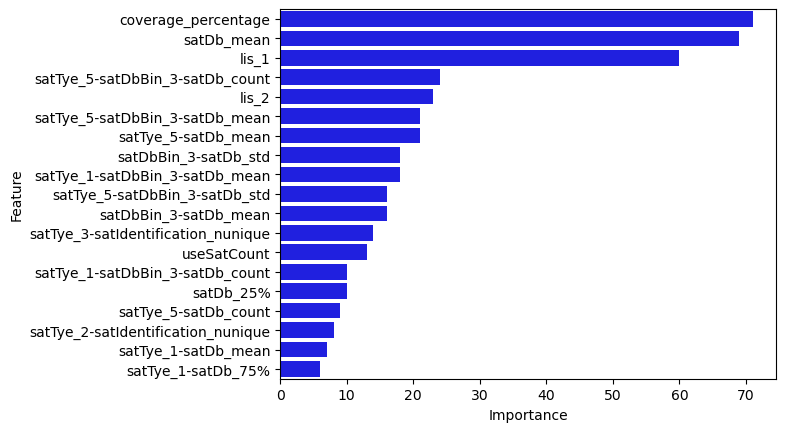

In [8]:
importance_df, unimportance_df = calculate_feature_importance_xgb(
    X_train[useful_feature_names], y_train, num_boost_round=200, importance_type='weight')
ordered_cols = importance_df.Feature.values.tolist()

sns.barplot(data=importance_df, x="Importance", y="Feature", color="b") # label="Total", 


## 模型

In [9]:
""" step 6. model """
# cols = X_train.columns
y = useful_feature_names

X_train, y_train, X_valid, y_valid = next(data_loader)
X_train_scaled, X_valid_scaled, scaler = standardize_df(X_train[y], X_valid[y])

2023-12-13 00:04:56.462 | DEBUG    | parse_sensor_data:group_kfold_split:126 - Training: ['z_深圳_上梅林-中康路_out_20231121-181755.zip', 'z_深圳_上梅林-九号路_out_20231114-180410.zip', 'z_深圳_上梅林-九号路_out_20231121-185019.zip', 'z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip', 'z_深圳_上梅林-地铁站_in_20231125-184008.zip', 'z_深圳_上梅林-星巴克_in_20231127-125841.zip', 'z_深圳_上梅林-理想城_out_20231121-185830.zip', 'z_深圳_上梅林-理想城周边_out_20231114-182526.zip', 'z_深圳_上梅林-站厅_in_20231114-210530.zip', 'z_深圳_上梅林-站厅_in_20231115-090633.zip', 'z_深圳_上梅林-站厅_in_20231121-182250.zip', 'z_深圳_上梅林-站厅_in_20231127-092422.zip', 'z_深圳_上梅林-站外5m_out_20231114-181054.zip', 'z_深圳_上梅林-站外_out_20231114-183323.zip', 'z_深圳_上梅林地铁站-站厅_in_20231208-190308.zip', 'z_深圳_上梅林地铁站-站厅_in_20231208-190937.zip', 'z_深圳_南山地铁站-E口外_in_20231116-072538.zip', 'z_深圳_南山地铁站-E口外_out_20231116-072412.zip', 'z_深圳_新一代-肯德基_in_20231125-183152.zip', 'z_深圳_新一代产业园_in_20231208-185638.zip', 'z_深圳_新一代产业园_out_20231208-190219.zip', 'z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip']
2023-12-13 00:04:56.467 | DEB

### 学习曲线

2023-12-13 00:11:13.771 | DEBUG    | model.model:plot_learning_curve:235 - Training score: 98.94%(std: 0.31), Validation score: 98.66%(std: 1.34)


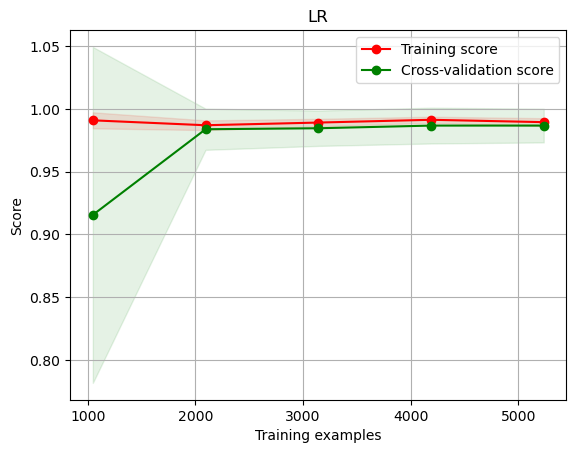

In [18]:
model_name = "LR"
clf = get_sklearn_model(model_name)

_X, y = scaler.transform(feats[y]), feats[LABEL]
cv_group_kfold = GroupKFold(n_splits=5).split(_X, y, records.loc[feats.index].fn)
plot_learning_curve(clf, model_name, _X, y, cv=cv_group_kfold, train_sizes=[.05, .2, .4, .6, .8, 1.0]);

### 评价模型

In [19]:
model_name = "LR"
clf = get_sklearn_model(model_name)

clf.fit(X_train_scaled, y_train)

LogisticRegression()

2023-12-13 00:11:16.298 | DEBUG    | parse_sensor_data:comprehensive_clf_report:379 - Training
              precision    recall  f1-score   support

         Out       0.98      1.00      0.99      3162
          In       0.99      0.97      0.98      2084

    accuracy                           0.99      5246
   macro avg       0.99      0.98      0.99      5246
weighted avg       0.99      0.99      0.99      5246



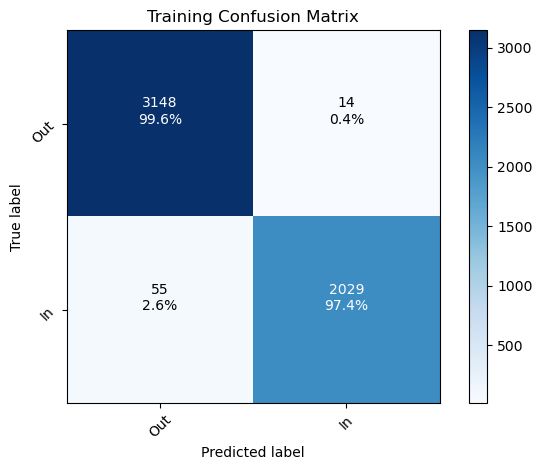

In [20]:
metric_lst = []
fig, _ = comprehensive_clf_report(clf, X_train, X_train_scaled, y_train, 'Training', metric_lst=metric_lst);
fig


2023-12-13 00:11:24.038 | WARNING  | parse_sensor_data:comprehensive_clf_report:379 - Validation
              precision    recall  f1-score   support

         Out       1.00      0.99      1.00      1180
          In       0.96      1.00      0.98       139

    accuracy                           1.00      1319
   macro avg       0.98      1.00      0.99      1319
weighted avg       1.00      1.00      1.00      1319



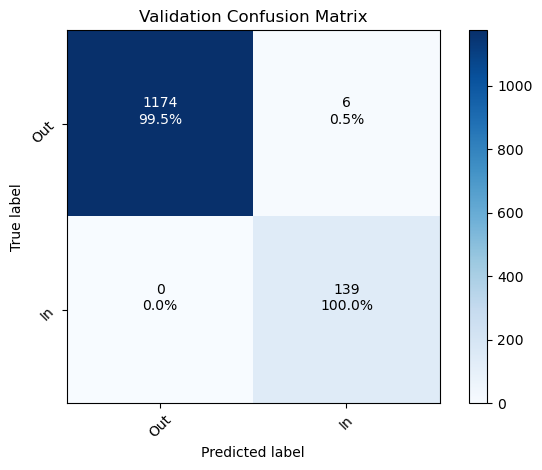

In [22]:
fig, _ = comprehensive_clf_report(clf, X_valid, X_valid_scaled, y_valid, 'Validation', metric_lst=metric_lst, level='warning')
fig

In [23]:
df_metric = pd.DataFrame(metric_lst)
df_metric

,Out_precision,Out_recall,In_precision,In_recall,accuracy,desc
0,0.982829,0.995572,0.993147,0.973608,0.986847,Training
1,1.000000,0.994915,0.958621,1.000000,0.995451,Validation
2,1.000000,0.994915,0.958621,1.000000,0.995451,Validation


### Bad Case

In [24]:
X, X_scaled, y = X_train, X_train_scaled, y_train
# X, X_scaled, y = X_valid, X_valid_scaled, y_valid
X, X_scaled, y = X.copy(), X_scaled.copy(), y.copy()

In [25]:
_X = add_predictions_and_labels(clf, X_scaled, y)

#### Out -> In

2023-12-13 00:11:30.444 | DEBUG    | model.data_analysis_visualization:plot_kde_grid:82 - plot kde plot for: Index(['coverage_percentage', 'satDb_mean', 'lis_1',
       'satTye_5-satDbBin_3-satDb_count', 'lis_2',
       'satTye_5-satDbBin_3-satDb_mean', 'satTye_5-satDb_mean',
       'satDbBin_3-satDb_std', 'satTye_1-satDbBin_3-satDb_mean',
       'satTye_5-satDbBin_3-satDb_std', 'satDbBin_3-satDb_mean',
       'satTye_3-satIdentification_nunique', 'useSatCount',
       'satTye_1-satDbBin_3-satDb_count', 'satDb_25%', 'satTye_5-satDb_count',
       'satTye_2-satIdentification_nunique', 'satTye_1-satDb_mean',
       'satTye_1-satDb_75%'],
      dtype='object'), except ['label']


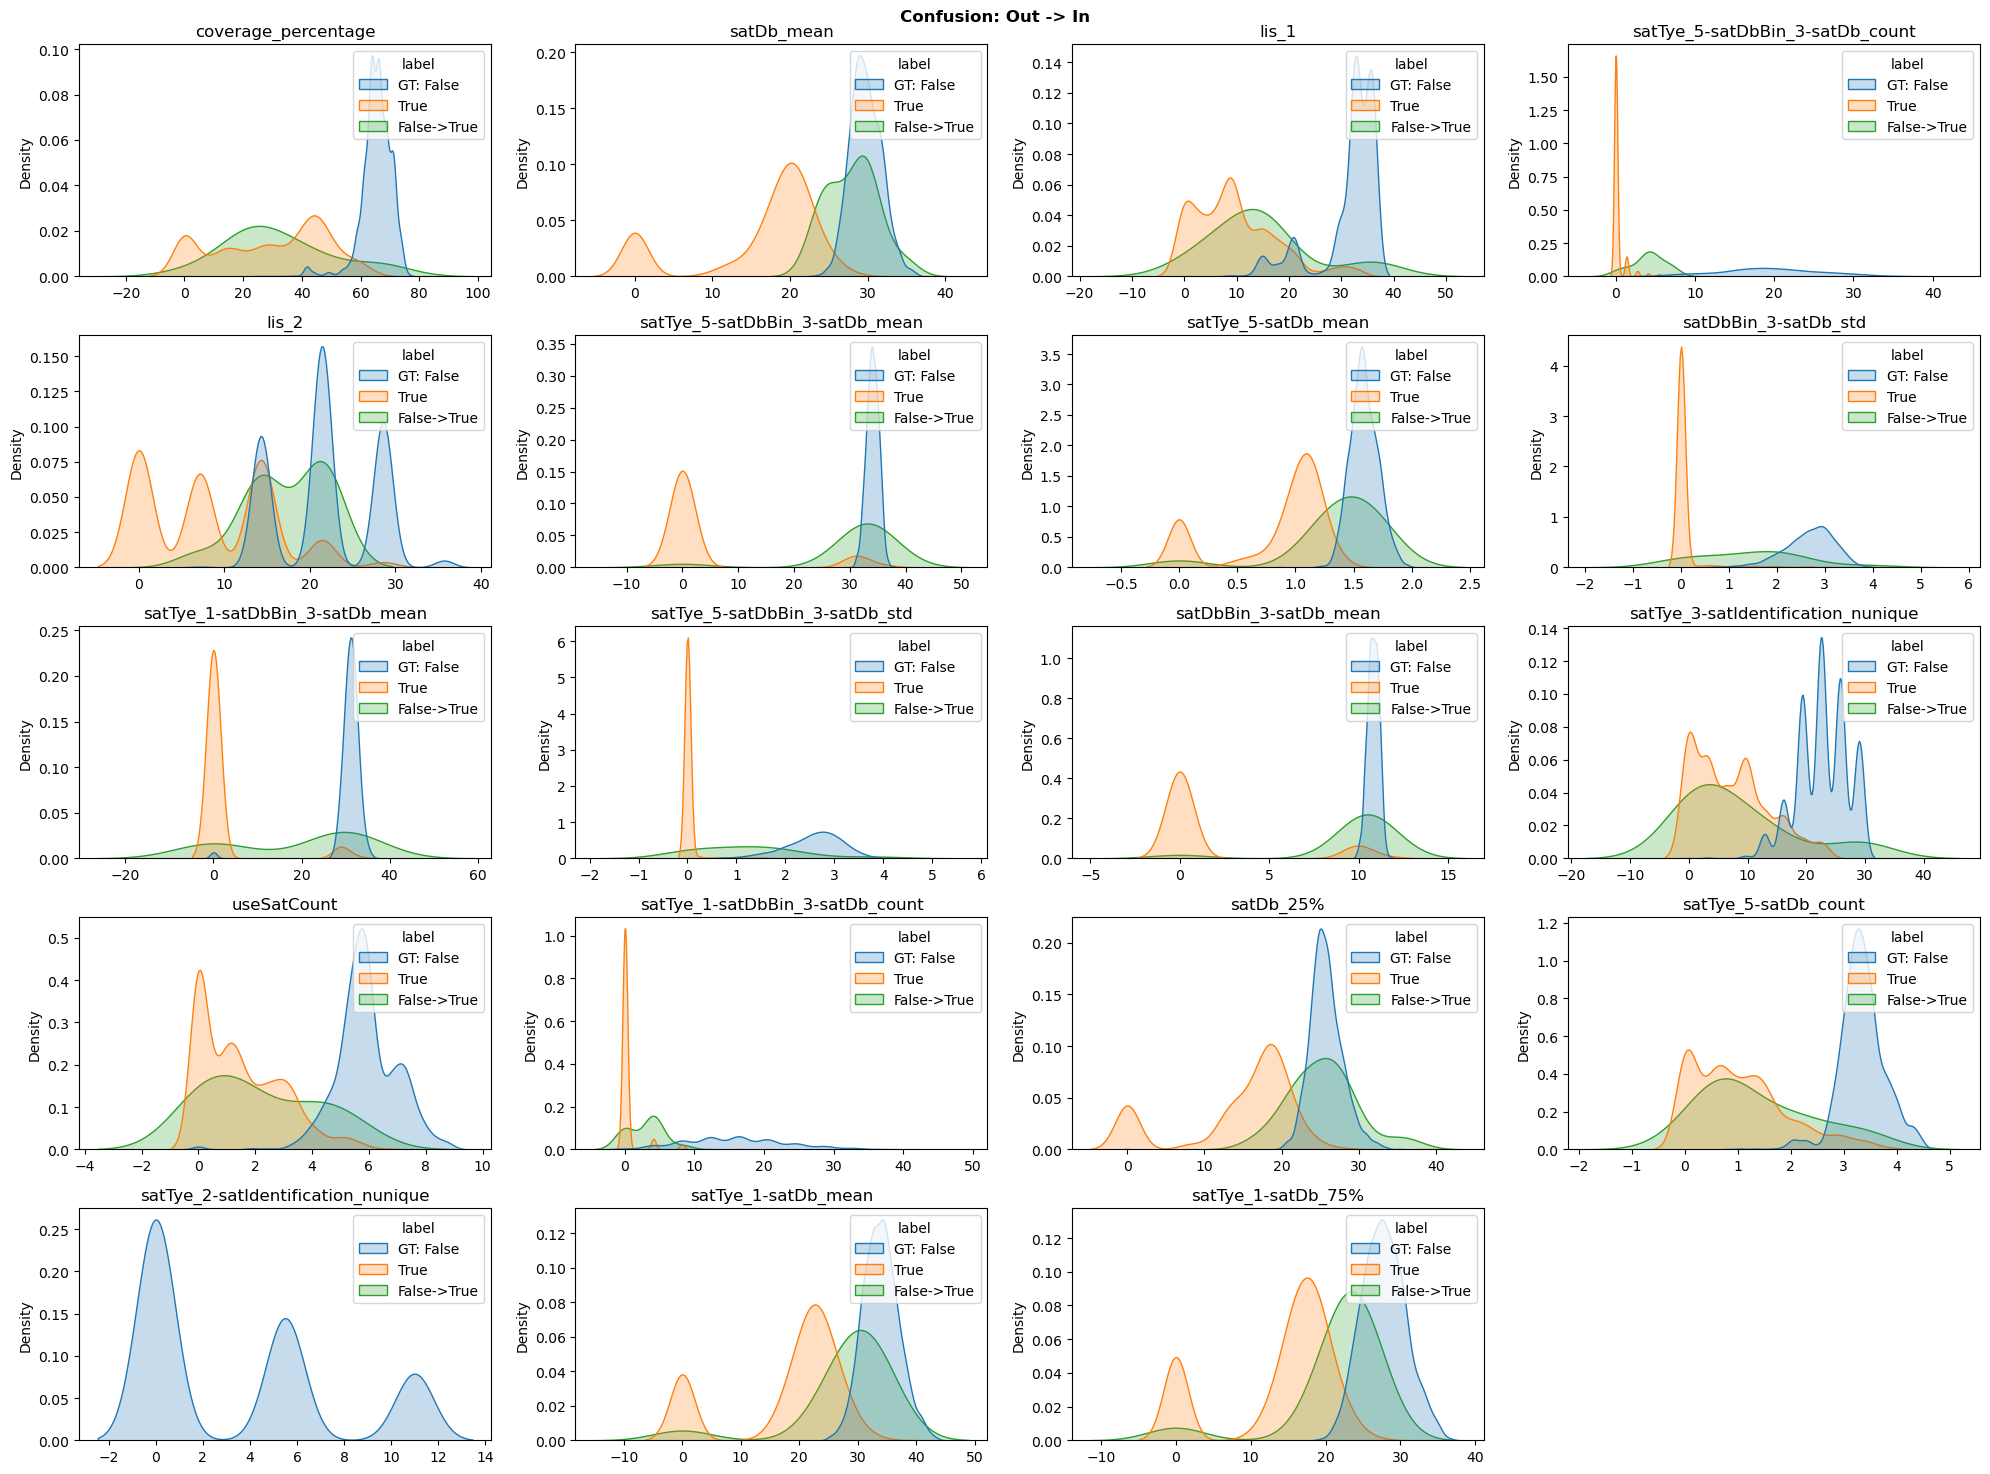

In [26]:
analyzed_data = visualize_confusion_features(
    _X, scaler=scaler, suptitle="Confusion: Out -> In", gt=False, pred=True, cols=ordered_cols)
idxs = analyzed_data[2].index
# df.loc[idxs]

In [27]:
get_sat_records(records, idxs, df_sat, keep_atts=['fn', 'aTime', 'satCount', 'useSatCount'])


,fn,aTime,satCount,useSatCount,num,Db_25,Db_50,Db_75,db_lst
3591,z_深圳_上梅林-站外5m_out_20231114-181054.zip,20231114-180907,71,43,43.0,21.0,23.0,27.00,"[32, 29, 29, 28, 28, 28, 28, 28, 28, 27, 27, 2..."
3597,z_深圳_上梅林-站外5m_out_20231114-181054.zip,20231114-180913,71,47,46.0,19.0,22.0,24.00,"[34, 31, 27, 27, 27, 27, 26, 25, 25, 25, 25, 2..."
5782,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190850,59,0,NaN,NaN,NaN,NaN,NaN
5783,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190851,59,0,NaN,NaN,NaN,NaN,NaN
5784,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190852,59,9,9.0,27.0,29.0,32.00,"[32, 32, 32, 31, 29, 28, 27, 23, 23]"
5785,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190853,59,10,10.0,27.0,28.0,32.50,"[37, 35, 33, 31, 29, 27, 27, 27, 23, 21]"
5786,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190854,70,14,14.0,25.0,26.5,29.50,"[35, 33, 32, 30, 28, 27, 27, 26, 25, 25, 25, 2..."
5789,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190857,70,18,18.0,23.5,26.5,31.75,"[33, 33, 33, 32, 32, 31, 31, 29, 27, 26, 26, 2..."
5799,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190907,70,33,31.0,20.0,24.0,27.00,"[35, 34, 33, 32, 32, 31, 28, 28, 26, 26, 26, 2..."
5800,z_深圳_上梅林-卓悦汇下沉广场_out_20231114-191104.zip,20231114-190908,70,33,31.0,20.0,24.0,28.50,"[36, 35, 34, 34, 32, 32, 32, 29, 28, 27, 26, 2..."


### In -> Out

2023-12-13 00:11:37.673 | DEBUG    | model.data_analysis_visualization:plot_kde_grid:82 - plot kde plot for: Index(['coverage_percentage', 'satDb_mean', 'lis_1',
       'satTye_5-satDbBin_3-satDb_count', 'lis_2',
       'satTye_5-satDbBin_3-satDb_mean', 'satTye_5-satDb_mean',
       'satDbBin_3-satDb_std', 'satTye_1-satDbBin_3-satDb_mean',
       'satTye_5-satDbBin_3-satDb_std', 'satDbBin_3-satDb_mean',
       'satTye_3-satIdentification_nunique', 'useSatCount',
       'satTye_1-satDbBin_3-satDb_count', 'satDb_25%', 'satTye_5-satDb_count',
       'satTye_2-satIdentification_nunique', 'satTye_1-satDb_mean',
       'satTye_1-satDb_75%'],
      dtype='object'), except ['label']


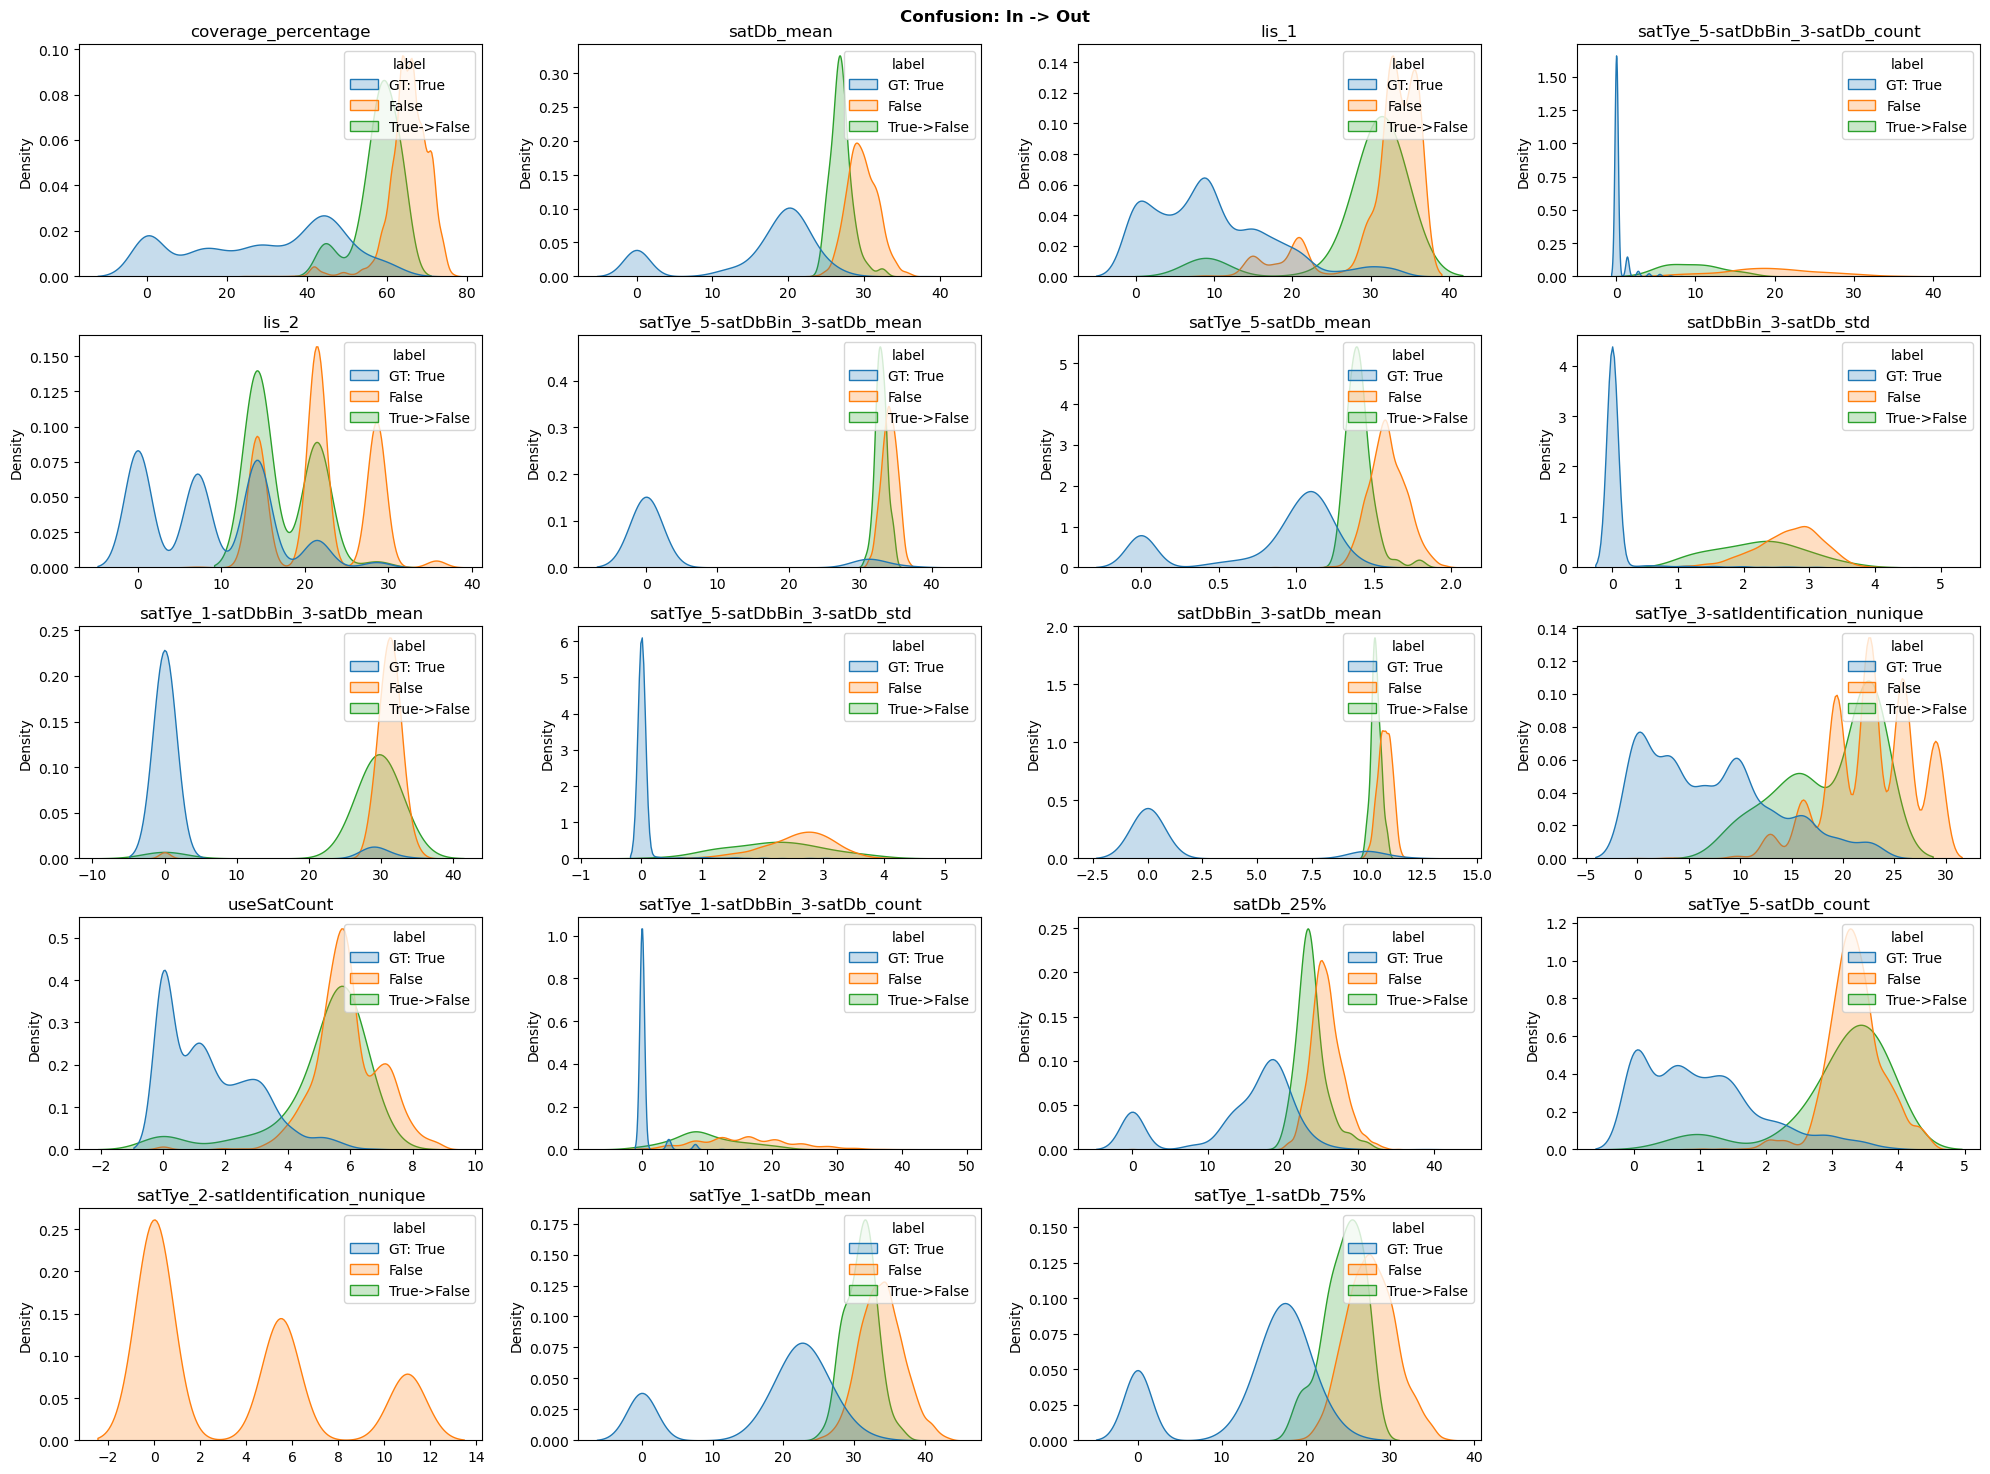

In [28]:
analyzed_data = visualize_confusion_features(
    _X, scaler=scaler, suptitle="Confusion: In -> Out", gt=True, pred=False, cols=ordered_cols)
idxs = analyzed_data[2].index


In [29]:
get_sat_records(records, idxs, df_sat, keep_atts=['fn', 'aTime', 'satCount', 'useSatCount'])

,fn,aTime,satCount,useSatCount,num,Db_25,Db_50,Db_75,db_lst
105,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183850,99,44,43.0,24.00,26.0,29.00,"[37, 34, 31, 31, 30, 30, 30, 30, 30, 29, 29, 2..."
106,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183851,99,48,47.0,23.00,26.0,29.00,"[34, 33, 33, 32, 32, 31, 31, 30, 29, 29, 29, 2..."
108,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183853,99,52,51.0,22.50,27.0,29.00,"[36, 34, 33, 32, 32, 31, 31, 31, 31, 30, 30, 2..."
109,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183854,70,55,54.0,23.00,26.0,28.00,"[38, 35, 34, 33, 32, 31, 30, 30, 30, 29, 29, 2..."
110,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183855,99,56,55.0,23.00,26.0,29.00,"[35, 35, 34, 34, 34, 31, 30, 30, 30, 30, 30, 3..."
111,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183856,99,57,56.0,22.75,26.0,28.00,"[37, 35, 35, 34, 33, 30, 30, 30, 30, 30, 30, 2..."
112,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183857,99,57,56.0,22.00,26.0,28.00,"[33, 33, 32, 31, 31, 31, 31, 30, 29, 29, 29, 2..."
116,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183901,99,53,52.0,23.50,26.5,30.00,"[35, 35, 34, 33, 32, 32, 32, 31, 31, 31, 30, 3..."
117,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183902,99,51,50.0,24.00,27.0,29.00,"[36, 34, 33, 32, 31, 31, 30, 30, 30, 30, 30, 3..."
118,z_深圳_上梅林-地铁站_in_20231125-184008.zip,20231125-183903,89,51,50.0,22.25,26.0,30.00,"[38, 36, 33, 32, 31, 31, 31, 31, 31, 31, 31, 3..."


In [30]:
detect_outlier(records, idxs)

,num,total_num,bad_ratio
fn,,,
z_深圳_南山地铁站-E口外_in_20231116-072538.zip,17,78,0.217949
z_深圳_上梅林-地铁站_in_20231125-184008.zip,22,182,0.120879
z_深圳_上梅林-站厅_in_20231115-090633.zip,11,308,0.035714
z_深圳_上梅林-站厅_in_20231114-210530.zip,5,367,0.013624


## EDA

In [31]:
records.head(5)

,aTime,altitude,latitude,longitude,satCount,timestamp,useSatCount,useSatEphemerisCount,satDataList,light_values,mobile_cid,fn,label
1,20231125-183706,34.237305,22.57341,114.0547,59,1700908626582,0,0,"[{'azimuth': 213.0, 'elevation': 40.0, 'isUseE...","[636.8, 7681.0, 6.0]",5.157574e+10,z_深圳_上梅林-地铁站_in_20231125-184008.zip,True
2,20231125-183707,34.237305,22.57341,114.0547,68,1700908627632,0,0,"[{'azimuth': 213.0, 'elevation': 40.0, 'isUseE...","[638.7, 9253.0, 6.0]",5.157574e+10,z_深圳_上梅林-地铁站_in_20231125-184008.zip,True
3,20231125-183708,34.237305,22.57341,114.0547,68,1700908628655,0,0,"[{'azimuth': 213.0, 'elevation': 40.0, 'isUseE...","[662.1, 8110.0, 6.0]",5.157574e+10,z_深圳_上梅林-地铁站_in_20231125-184008.zip,True
4,20231125-183709,34.237305,22.57341,114.0547,68,1700908629635,0,0,"[{'azimuth': 163.0, 'elevation': 36.0, 'isUseE...","[618.3, 6363.0, 6.0]",5.157574e+10,z_深圳_上梅林-地铁站_in_20231125-184008.zip,True
5,20231125-183710,34.237305,22.57341,114.0547,81,1700908630640,0,0,"[{'azimuth': 163.0, 'elevation': 36.0, 'isUseE...","[293.5, 3769.0, 6.0]",5.157574e+10,z_深圳_上梅林-地铁站_in_20231125-184008.zip,True


In [32]:
df_sat.head()

,azimuth,elevation,isUseEphemeris,isUsed,satDb,satFrequency,satIdentification,satTye,rid
0,213.0,40.0,1.0,False,23.600000,1575.420044,4,1,1
48,99.0,43.0,1.0,False,22.700001,1575.420044,11,6,1
59,213.0,40.0,1.0,False,21.600000,1575.420044,4,1,2
73,252.0,20.0,1.0,False,24.700001,1604.810059,3,3,2
74,301.0,12.0,1.0,False,24.799999,1605.380005,4,3,2


### 搜星稳定性模式

In [33]:
def fetch_startup_gnss_data(records, windows_size=60, 
                            keep_atts=['fn', 'timestamp', 'satCount', 'useSatCount']):
    filter_idxs = records.sort_values(['fn', 'timestamp'])\
                          .groupby('fn')\
                          .head(windows_size*1.5).index
    df = get_sat_records(records, filter_idxs, df_sat, keep_atts)
    name_2_start_time = df.groupby('fn').agg({'timestamp': 'min'})
    df.loc[:, 'dt'] = df.apply(lambda x: (x.timestamp - name_2_start_time.loc[x.fn]) / 1000, axis=1).astype(int)
    df.query(f"dt < {windows_size}", inplace=True)
    df = append_label(df, records)

    return df

df_fisrt_minute = fetch_startup_gnss_data(records)
df_fisrt_minute


,fn,timestamp,satCount,useSatCount,num,Db_25,Db_50,Db_75,db_lst,dt,label
5187,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561630515,77,52,39.0,29.00,33.0,36.00,"[43, 40, 40, 40, 38, 38, 37, 36, 36, 36, 36, 3...",0,False
5188,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561631357,91,0,NaN,NaN,NaN,NaN,NaN,0,False
5189,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561632352,102,51,50.0,28.00,31.0,37.75,"[44, 42, 41, 41, 40, 40, 40, 40, 39, 39, 38, 3...",1,False
5190,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561633369,102,61,59.0,29.00,34.0,37.50,"[45, 44, 44, 42, 42, 41, 41, 40, 40, 40, 39, 3...",2,False
5191,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561634363,102,68,68.0,26.75,29.0,34.25,"[41, 40, 40, 40, 39, 38, 38, 37, 37, 37, 37, 3...",3,False
...,...,...,...,...,...,...,...,...,...,...,...
4702,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035081228,57,0,NaN,NaN,NaN,NaN,NaN,55,True
4703,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035082227,57,0,NaN,NaN,NaN,NaN,NaN,56,True
4704,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035083221,57,0,NaN,NaN,NaN,NaN,NaN,57,True
4705,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035084225,57,0,NaN,NaN,NaN,NaN,NaN,58,True


<Axes: xlabel='dt', ylabel='useSatCount'>

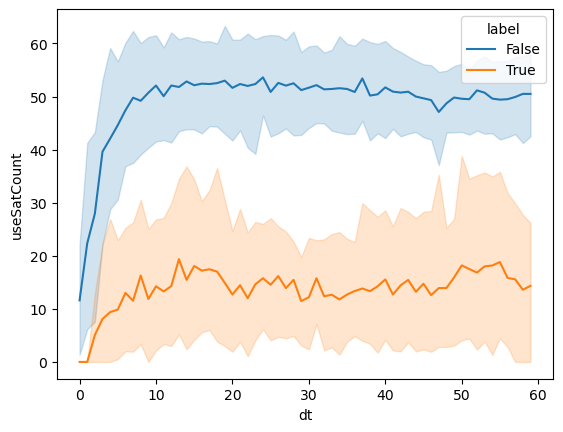

In [34]:
sns.lineplot(data=df_fisrt_minute, x='dt', y='useSatCount', hue=LABEL, ci=100)

<Axes: xlabel='dt', ylabel='Db_25'>

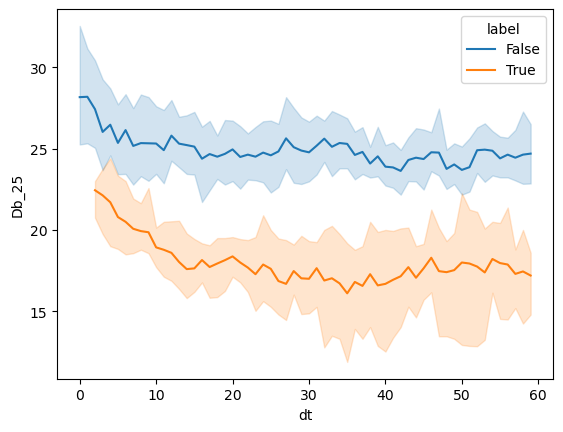

In [35]:
sns.lineplot(data=df_fisrt_minute, x='dt', y='Db_25', hue=LABEL, ci=100)


In [1]:
import math

def plot_grid(plot_func, data, x, y, plot_params=None, n_col=4, suptitle=None):
    _len = len(y)
    if n_col > _len: n_col = _len
    n_row = math.ceil(_len / n_col)
    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col * 5, n_row * 3))
    if n_row * n_col > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for i, col in enumerate(y):
        if i < n_row * n_col:
            plot_func(data=data, x=x, y=col, ax=axes[i], **plot_params,)
            axes[i].set_title(col)
            axes[i].set_xlabel("")
        else:
            break

    for j in range(i + 1, n_row * n_col):
        axes[j].axis("off")

    if suptitle:
        plt.suptitle(suptitle, fontweight='bold')
    plt.tight_layout()

    return fig, axes


attrs = ['Db_25', 'Db_50', 'Db_75']
plot_params = {'hue': LABEL, 'ci': 100}
fig, axes = plot_grid(sns.lineplot, df_fisrt_minute, 'dt', attrs, 3, plot_params);

for ax in  axes:
    ax.set_ylim(0, 40)


NameError: name 'LABEL' is not defined

In [41]:
df_fisrt_minute

,fn,timestamp,satCount,useSatCount,num,Db_25,Db_50,Db_75,db_lst,dt,label
5187,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561630515,77,52,39.0,29.00,33.0,36.00,"[43, 40, 40, 40, 38, 38, 37, 36, 36, 36, 36, 3...",0,False
5188,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561631357,91,0,NaN,NaN,NaN,NaN,NaN,0,False
5189,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561632352,102,51,50.0,28.00,31.0,37.75,"[44, 42, 41, 41, 40, 40, 40, 40, 39, 39, 38, 3...",1,False
5190,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561633369,102,61,59.0,29.00,34.0,37.50,"[45, 44, 44, 42, 42, 41, 41, 40, 40, 40, 39, 3...",2,False
5191,z_深圳_上梅林-中康路_out_20231121-181755.zip,1700561634363,102,68,68.0,26.75,29.0,34.25,"[41, 40, 40, 40, 39, 38, 38, 37, 37, 37, 37, 3...",3,False
...,...,...,...,...,...,...,...,...,...,...,...
4702,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035081228,57,0,NaN,NaN,NaN,NaN,NaN,55,True
4703,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035082227,57,0,NaN,NaN,NaN,NaN,NaN,56,True
4704,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035083221,57,0,NaN,NaN,NaN,NaN,NaN,57,True
4705,z_深圳_车公庙-9号线-11号线_in_20231208-193316.zip,1702035084225,57,0,NaN,NaN,NaN,NaN,NaN,58,True
